In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set up the dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(100, 7 * 7 * 256, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(256)
        self.leaky_relu = nn.LeakyReLU()

        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(128)

        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(64)

        self.conv3 = nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=1, output_padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)

        x = x.view(-1, 7, 7, 256)

        x = self.conv1(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)

        x = self.conv2(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu(x)

        x = self.conv3(x)
        x = self.tanh(x)

        return x


generator = Generator()

out = generator(torch.randn(1, 100))
out.shape

ValueError: expected 4D input (got 2D input)

In [53]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2)
        self.leaky_relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.leaky_relu2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(7 * 7 * 128, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = self.fc(x)

        return x

# Instantiate the discriminator
discriminator = Discriminator()

In [58]:
# Define the loss and optimizers
discriminator = Discriminator()
generator = Generator()

criterion = nn.BCEWithLogitsLoss()
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001)
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001)

In [59]:
# Define the training loop
def train(epoch):
    for i, (images, _) in enumerate(trainloader):
        noise = torch.randn(64, 100)

        fake_images = generator(noise)

        concatenated_images = torch.cat([ images, fake_images ], 0)

        predictions = discriminator(concatenated_images)

        labels = torch.cat([
            +1 * torch.ones( len(images),      1 ), 
            -1 * torch.ones( len(fake_images), 1 )
        ])
        d_loss = criterion(predictions, labels)

        discriminator.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        noise = torch.randn(64, 100)
        fake_images = generator(noise)

        predictions = discriminator(fake_images.detach())

        g_loss = criterion(predictions, torch.ones(len(fake_images), 1))

        generator.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        # Print progress
        if (i + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}: {d_loss.item()}, {g_loss.item()}")

for epoch in range(10):
    train(epoch)

torch.save(generator.state_dict(), "../models/mnist-gan-generator.pt")
torch.save(discriminator.state_dict(), "../models/mnist-gan-discriminator.pt")

Epoch 1: 0.4254983365535736, 0.8891637325286865
Epoch 1: -0.14464974403381348, 1.4986387491226196
Epoch 1: -1.1225173473358154, 3.035031795501709
Epoch 1: -2.6546897888183594, 6.061061859130859
Epoch 1: -5.1285247802734375, 10.861201286315918
Epoch 1: -8.763349533081055, 18.291431427001953
Epoch 1: -13.697341918945312, 28.242097854614258
Epoch 1: -19.999195098876953, 41.21295928955078


KeyboardInterrupt: 

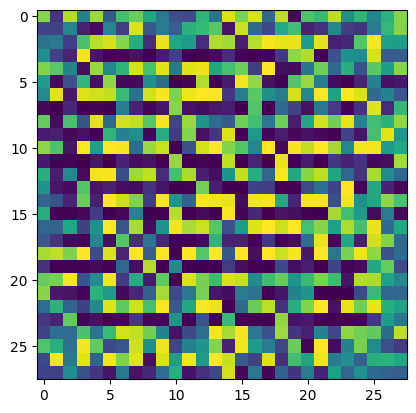

In [57]:
noise = torch.randn(1, 100)
fake_image = generator(noise)

predictions = discriminator(fake_image)
plt.imshow(fake_image[0, 0].detach())
plt.show()